In [ ]:
# Date - 23/01/2026
# Task - Signature verification

In [ ]:
# Install the kaggle API client
!pip install kaggle

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
import os
import subprocess

DATA_DIR = "data"

DATASET = "shreelakshmigp/cedardataset"

def download_kaggle_dataset():
    os.makedirs(DATA_DIR, exist_ok=True)

    subprocess.run([
        "kaggle", "datasets", "download",
        DATASET,
        "-p", DATA_DIR,
        "--unzip"
    ])

if __name__ == "__main__":
    download_kaggle_dataset()

In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
from PIL import Image


In [ ]:
IMG_H, IMG_W = 155, 220
BATCH_SIZE = 16
EPOCHS = 5
MARGIN = 1.0


In [ ]:
org_dir = "data/signatures/full_org"
forg_dir = "data/signatures/full_forg"


genuine = {}
forged = {}

for fname in os.listdir(org_dir):
    parts = fname.split("_")
    if len(parts) >= 3:
        writer = parts[1]   # middle part is the writer ID
        genuine.setdefault(writer, []).append(os.path.join(org_dir, fname))
    else:
        print("Skipping unexpected filename:", fname)

for fname in os.listdir(forg_dir):
    parts = fname.split("_")
    if len(parts) >= 3:
        writer = parts[1]
        forged.setdefault(writer, []).append(os.path.join(forg_dir, fname))
    else:
        print("Skipping unexpected filename:", fname)


Skipping unexpected filename: Thumbs.db
Skipping unexpected filename: Thumbs.db


In [ ]:
print("Number of writers:", len(genuine))
first_writer = next(iter(genuine))
print("Writer ID:", first_writer)
print("Genuine samples:", len(genuine[first_writer]))
print("Forged samples:", len(forged.get(first_writer, [])))


Number of writers: 55
Writer ID: 53
Genuine samples: 24
Forged samples: 24


In [ ]:
pairs = []

for writer in genuine:
    g = genuine[writer]
    f = forged.get(writer, [])

    # genuine–genuine
    for i in range(len(g)):
        for j in range(i + 1, len(g)):
            pairs.append((g[i], g[j], 0))

    # genuine–forgery
    for gi in g:
        for fi in f:
            pairs.append((gi, fi, 1))

random.shuffle(pairs)
pairs = pairs[:8000]   # limit size for Colab


In [ ]:
def load_image(path):
    img = Image.open(path).convert("L")
    img = img.resize((IMG_W, IMG_H))
    img = np.array(img).astype("float32")
    img = (img / 255.0 - 0.5) / 0.5
    img = np.expand_dims(img, axis=-1)
    return img


In [ ]:
cnn = tf.keras.Sequential([
    tf.keras.Input(shape=(IMG_H, IMG_W, 1)),
    tf.keras.layers.Conv2D(96, 11, activation='relu'),
    tf.keras.layers.MaxPooling2D(3, strides=2),

    tf.keras.layers.Conv2D(256, 5, activation='relu'),
    tf.keras.layers.MaxPooling2D(3, strides=2),

    tf.keras.layers.Conv2D(384, 3, activation='relu'),
    tf.keras.layers.Conv2D(256, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(3, strides=2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128)
])


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

In [ ]:
# Training
for epoch in range(EPOCHS):
    random.shuffle(pairs)
    total_loss = 0
    steps = 0

    for i in range(0, len(pairs), BATCH_SIZE):
        batch = pairs[i:i + BATCH_SIZE]
        if len(batch) < BATCH_SIZE:
            continue

        img1 = np.array([load_image(p[0]) for p in batch])
        img2 = np.array([load_image(p[1]) for p in batch])
        labels = tf.convert_to_tensor([p[2] for p in batch], dtype=tf.float32)

        with tf.GradientTape() as tape:
            out1 = cnn(img1, training=True)
            out2 = cnn(img2, training=True)

            dist = tf.norm(out1 - out2, axis=1)
            loss = tf.reduce_mean(
                (1 - labels) * tf.square(dist) +
                labels * tf.square(tf.maximum(MARGIN - dist, 0))
            )

        grads = tape.gradient(loss, cnn.trainable_variables)
        optimizer.apply_gradients(zip(grads, cnn.trainable_variables))

        total_loss += loss.numpy()
        steps += 1

    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {total_loss / steps:.4f}")


Epoch 1/5 - Loss: 0.1656
Epoch 2/5 - Loss: 0.0377
Epoch 3/5 - Loss: 0.0094
Epoch 4/5 - Loss: 0.0102
Epoch 5/5 - Loss: 0.0089


In [ ]:
w = list(genuine.keys())[0]

imgA = load_image(genuine[w][0])[None, ...]
imgB = load_image(forged[w][0])[None, ...]

embA = cnn(imgA, training=False)
embB = cnn(imgB, training=False)

distance = tf.norm(embA - embB, axis=1)
print("Distance:", distance.numpy()[0])


Distance: 1.6709347


In [ ]:
import tensorflow as tf
import numpy as np

def predict_signature_authenticity(image_path1, image_path2, threshold):
    img1 = load_image(image_path1)
    img2 = load_image(image_path2)

    # Add batch dimension for the model input
    img1 = np.expand_dims(img1, axis=0)
    img2 = np.expand_dims(img2, axis=0)

    # Get embeddings from the trained CNN. Set training=False for inference.
    emb1 = cnn(img1, training=False)
    emb2 = cnn(img2, training=False)

    # Calculate Euclidean distance
    distance = tf.norm(emb1 - emb2, axis=1).numpy()[0]

    if distance < threshold:
        return True, distance  # Genuine
    else:
        return False, distance # Forged


Using a prediction threshold of: 0.60

Comparing a genuine and a forged signature of writer 17:
  Genuine Signature: data/signatures/full_org/original_17_20.png
  Forged Signature: data/signatures/full_forg/forgeries_17_20.png
  Distance: 3.4470
  Predicted as Genuine: False



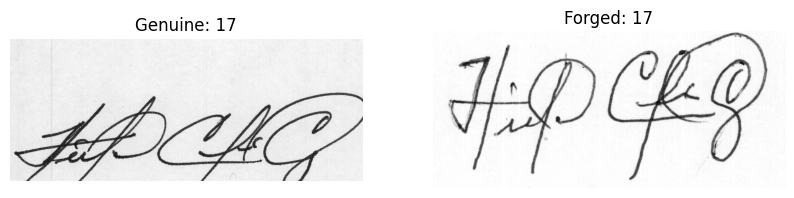

In [ ]:
import matplotlib.pyplot as plt
prediction_threshold = 0.6

print(f"Using a prediction threshold of: {prediction_threshold:.2f}\n")
example_writer_id = '17'

# Picking one genuine and one forged signature from the same writer
if example_writer_id in genuine and example_writer_id in forged and \
   len(genuine[example_writer_id]) >= 1 and len(forged[example_writer_id]) >= 1:
    gen_sig_path = genuine[example_writer_id][0]
    forg_sig_path = forged[example_writer_id][0]

    is_genuine, dist = predict_signature_authenticity(gen_sig_path, forg_sig_path, prediction_threshold)
    print(f"Comparing a genuine and a forged signature of writer {example_writer_id}:")
    print(f"  Genuine Signature: {gen_sig_path}")
    print(f"  Forged Signature: {forg_sig_path}")
    print(f"  Distance: {dist:.4f}")
    print(f"  Predicted as Genuine: {is_genuine}\n")

    # Display images
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(Image.open(gen_sig_path).convert('L'), cmap='gray')
    axes[0].set_title(f"Genuine: {example_writer_id}")
    axes[0].axis('off')

    axes[1].imshow(Image.open(forg_sig_path).convert('L'), cmap='gray')
    axes[1].set_title(f"Forged: {example_writer_id}")
    axes[1].axis('off')
    plt.show()

else:
    print(f"Not enough genuine or forged signatures for writer {example_writer_id} to create a forged pair example.\n")
